In [1]:
import json
import shutil
import sys
from itertools import count
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.sparse import dok_matrix

from keras.datasets import mnist
from sklearn.datasets import make_moons
from sklearn.cluster import k_means, spectral_clustering, SpectralClustering

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

from model import LocalDictionary
from utils import *

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [2]:
def load_mnist(digits=list(range(10))):
    def sample(n, std=0.1):
        y = F.normalize(torch.randn(n, 3), dim=1)
        y[:, 2] *= -y[:, 2].sign()
        y += std * torch.randn(y.shape)
        return y

    (y_train, l_train), (y_test, l_test) = mnist.load_data()

    y_train = torch.tensor(y_train).view(-1, 784) / 255.0
    y_test = torch.tensor(y_test).view(-1, 784) / 255.0

    i_train = l_train < 0
    i_test = l_test < 0

    for d in digits:
        i_train |= l_train == d
        i_test |= l_test == d

    y_train = y_train[i_train]
    l_train = l_train[i_train]
    y_test = y_test[i_test]
    l_test = l_test[i_test]

    def show(net, writer, path=None, epoch=0, colors=None):
        with torch.no_grad():
            net.eval()
            x_hat_test = net.encode(y_test)
            y_hat_test = net.decode(x_hat_test)

            def tile(images, colors=None):

                if colors is None:
                    colors = np.full((len(images),), -1)

                code = np.array(
                    [
                        [1.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0],
                        [0.0, 1.0, 1.0],
                        [1.0, 1.0, 0.0],
                        [0.5, 0.0, 1.0],
                        [1.0, 1.0, 1.0],
                    ]
                )

                i = 1
                while i * i <= images.shape[0]:
                    if images.shape[0] % i == 0:
                        h = i
                    i += 1
                w = images.shape[0] // h

                na = np.newaxis
                images = images[..., na] * code[colors][:, na, na, :]
                # ^^^ WORK IN PROGRESS, NOT TESTED vvv
                return (
                    images.view(h, w, *images.shape[1:])
                    .permute(0, 2, 1, 3, 4)
                    .reshape(h * images.shape[1], w * images.shape[2], 3)
                )

            W = tile(net.W.data.view(-1, 28, 28), colors)
            plt.imshow(W.clamp(0, 1))
            plt.xticks([], [])
            plt.yticks([], [])
            if path:
                plt.tight_layout()
                plt.savefig(path, dpi=300)
            plt.show()
            if epoch is not None:
                writer.add_images(
                    "dictionary",
                    net.W.data.view(-1, 1, 28, 28).clamp(0, 1),
                    global_step=epoch,
                )

            p = torch.randperm(y_test.shape[0])[:24]
            reconstructions = torch.stack([y_test[p], y_hat_test[p]]).clamp(0, 1)
            reconstructions = reconstructions.clone().detach().cpu()
            if epoch is not None:
                writer.add_images(
                    "reconstructions",
                    reconstructions.permute(1, 0, 2).reshape(-1, 1, 28, 28),
                    global_step=epoch,
                )

            print(x_hat_test[p].bool().float().sum(dim=1).mean())

            plt.imshow(
                tile(reconstructions.permute(1, 0, 2).reshape(-1, 28, 28)), cmap="gray"
            )
            plt.xticks([], [])
            plt.yticks([], [])
            plt.show()

            writer.flush()

    return y_train, l_train, y_test, l_test, show

In [3]:
name = "results"
n_digits = 5

path = Path(f"res/{name}")
path.mkdir(exist_ok=True, parents=True)

for child in path.iterdir():
    if child.is_file():
        child.unlink()

writer = SummaryWriter(path)

(path / "figs").mkdir(exist_ok=True, parents=True)

y_train, l_train, y_test, l_test, show = load_mnist(digits=[0, 1, 3, 6, 7])

In [4]:
def fancy_init(net, y):
    n = y.shape[0]
    m = net.W.shape[0]
    d = torch.ones(n)
    for i in range(m):
        net.W.data[i] = y[torch.multinomial(d, 1)]
        d1 = (y - net.W.data[i]).norm(dim=1)
        d = d1 if i == 0 else torch.min(d, d1)

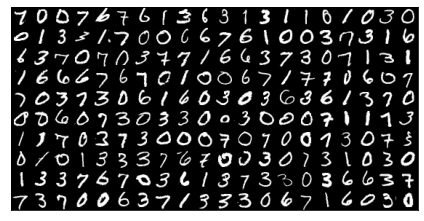

tensor(14.4583)


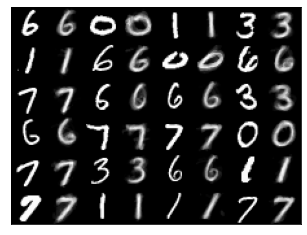

step size = 0.00012281702947802842
default loss = (tensor(10.1333), tensor(45.8758), tensor(56.0091))


In [5]:
penalty = 1.0
net = LocalDictionary(15, 784, 200, penalty)
optimizer = optim.Adam(net.parameters())
criterion = LocalDictionaryLoss(penalty)

with torch.no_grad():
    fancy_init(net, y_train)
    net.step.fill_((net.W.data.svd()[1][0] ** -2).item())

show(net, writer, path / "figs/0.png", epoch=0)
print("step size =", net.step.item())
with torch.no_grad():
    print("default loss =", criterion.forward_detailed(net.W, y_test, net.encode(y_test)))

In [6]:
epoch = 0
i = 0

 20%|█▉        | 199/1000 [00:14<00:58, 13.60it/s]

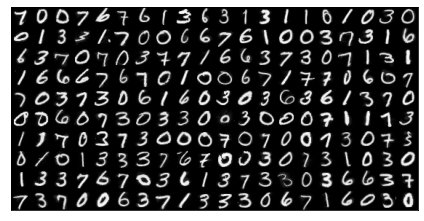

tensor(2.8333)


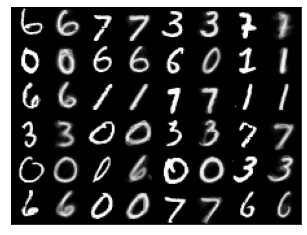

 40%|███▉      | 399/1000 [00:30<00:42, 13.98it/s]

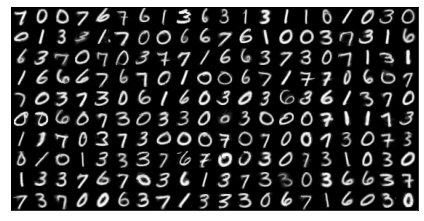

tensor(2.5000)


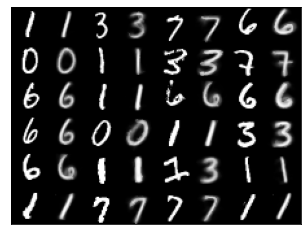

 60%|█████▉    | 598/1000 [00:47<00:29, 13.54it/s]

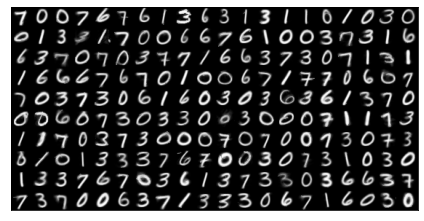

tensor(1.7917)


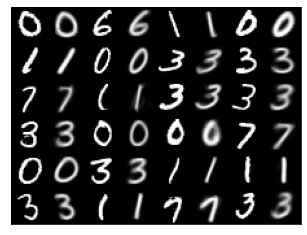

 80%|███████▉  | 798/1000 [01:03<00:14, 13.59it/s]

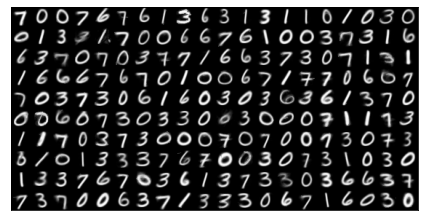

tensor(2.)


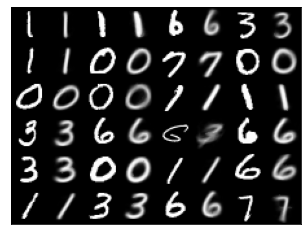

100%|█████████▉| 998/1000 [01:19<00:00, 13.53it/s]

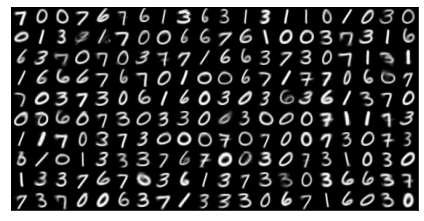

tensor(1.8750)


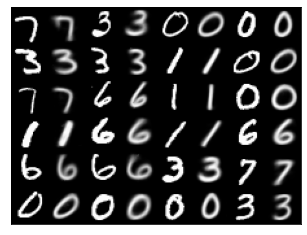

100%|██████████| 1000/1000 [01:21<00:00, 12.23it/s]


In [7]:
epochs = 1000
batch_size = 1024
device = "cuda:0"

net = net.to(device)
net.train()

n = y_train.shape[0]

for epoch in tqdm(range(epoch, epoch + epochs)):
    if i >= n:
        i = i % n
        p = torch.randperm(n)
        y_train, l_train = y_train[p], l_train[p]
    
    y_subset = y_train[i : i + batch_size].to(device)
    x_hat_subset = net.encode(y_subset)
    
    optimizer.zero_grad()
    rec, pen, tot = criterion.forward_detailed(net.W, y_subset, x_hat_subset)
    writer.add_scalar("loss (rec.)", rec.item(), global_step=epoch + 1)
    writer.add_scalar("loss (pen.)", pen.item(), global_step=epoch + 1)
    writer.add_scalar("loss", tot.item(), global_step=epoch + 1)
    tot.backward()
    nn.utils.clip_grad_norm_(net.parameters(), 1e-4)
    optimizer.step()
    
    
    writer.add_scalar("degree", x_hat_subset.bool().float().sum(dim=1).mean().item(), global_step=epoch + 1)
    
    frequency = 200
    if (epoch + 1) % frequency == 0:
        net = net.cpu()
        show(net, writer, path / f"figs/{epoch+1}.png", epoch + 1)
        net = net.to(device)
        net.train()
    
    i += batch_size

net = net.cpu()

In [8]:
print("step size =", net.step.item())
with torch.no_grad():
    print("default loss =", criterion.forward_detailed(net.W, y_test, net.encode(y_test)))

step size = 0.02357425168156624
default loss = (tensor(9.4589), tensor(21.6840), tensor(31.1429))


Mean L0 = 1.9454118013381958
Median L0 = 2.0
Sanity check (should equal 1.0) = 1.0


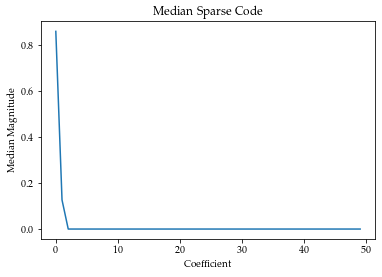

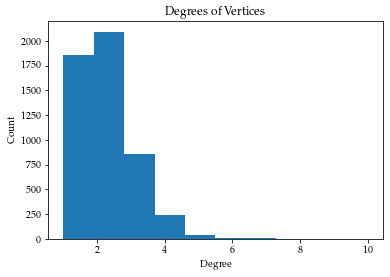

In [9]:
net = net.cpu()

with torch.no_grad():
    x_hat_test = net.encode(y_test)
    y_hat_test = net.decode(x_hat_test)

print("Mean L0 =", (x_hat_test.abs() > 0).float().sum(dim=1).mean().item())
print("Median L0 =", (x_hat_test.abs() > 0).float().sum(dim=1).median().item())
print("Sanity check (should equal 1.0) =", x_hat_test.abs().sum(dim=1).mean().item())

msc = x_hat_test.clone().sort(descending=True, dim=1).values.median(dim=0).values
plt.plot(msc[:50])
plt.xlabel('Coefficient')
plt.ylabel('Median Magnitude')
plt.title('Median Sparse Code')
plt.show()

deg = x_hat_test.clone().bool().float().sum(dim=1)
plt.hist(deg)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degrees of Vertices')
plt.show()

In [10]:
%%time

n = y_test.shape[0]
m = net.hidden_size

print("making graph...")
sim = dok_matrix((n + m, n + m), dtype=np.float32)
for i, j in tqdm(x_hat_test.nonzero()):
    sim[i, n + j] = x_hat_test[i, j]

print("clustering...")
l_hat_test = spectral_clustering(sim, n_clusters=n_digits)

print("calculating accuracy...")
print(acc(l_test, torch.tensor(l_hat_test)[:-net.hidden_size])[0])

 33%|███▎      | 3301/9943 [00:00<00:00, 33004.52it/s]

making graph...


100%|██████████| 9943/9943 [00:00<00:00, 32918.38it/s]
/home/ptankala/.conda/envs/pranay/lib/python3.7/site-packages/sklearn/utils/validation.py:72: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(**kwargs)


clustering...
calculating accuracy...
0.9802387008413226
CPU times: user 10.2 s, sys: 3.97 s, total: 14.2 s
Wall time: 1.8 s


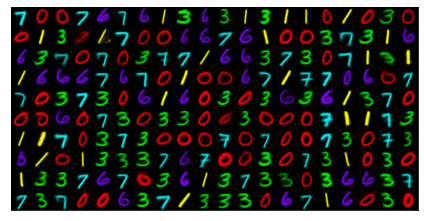

tensor(2.2917)


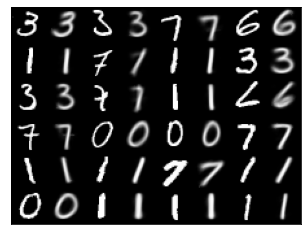

In [11]:
show(net, writer, path = path / "figs/color.png", colors=l_hat_test[-net.W.shape[0]:].astype(np.int))

In [12]:
%%time

print("clustering...")
sc = SpectralClustering(n_clusters=n_digits, affinity="nearest_neighbors", n_neighbors=5)
l_sc_test = sc.fit_predict(y_test)

print("calculating accuracy...")
print(acc(l_test, torch.tensor(l_sc_test))[0])

clustering...
calculating accuracy...
0.9804343572686363
CPU times: user 40.5 s, sys: 7.25 s, total: 47.8 s
Wall time: 28.8 s


In [13]:
%%time

n = y_train.shape[0]
m = net.hidden_size

with torch.no_grad():
    x_hat_train = net.encode(y_train)
    y_hat_train = net.decode(x_hat_train)

print("making graph...")
sim_train = dok_matrix((n + m, n + m), dtype=np.float32)
for i, j in tqdm(x_hat_train.nonzero()):
    sim_train[i, n + j] = x_hat_train[i, j]

print("clustering...")
l_hat_train = spectral_clustering(sim_train, n_clusters=n_digits)

print("calculating accuracy...")
print(acc(l_train, torch.tensor(l_hat_train)[:-net.hidden_size])[0])

  1%|▏         | 822/57035 [00:00<00:06, 8219.34it/s]

making graph...


100%|██████████| 57035/57035 [00:01<00:00, 29993.71it/s]
/home/ptankala/.conda/envs/pranay/lib/python3.7/site-packages/sklearn/utils/validation.py:72: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(**kwargs)


clustering...
calculating accuracy...
0.9779528067400497
CPU times: user 1min 22s, sys: 1min 47s, total: 3min 9s
Wall time: 57.3 s


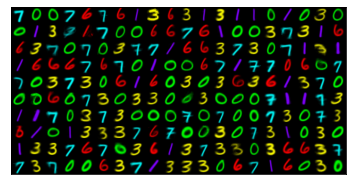

tensor(1.9583)


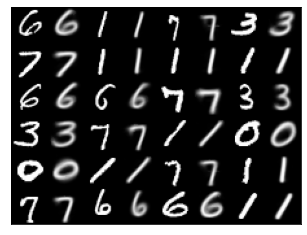

In [14]:
show(net, writer, colors=l_hat_train[-net.W.shape[0]:].astype(np.int))